Formula 1

In [104]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [105]:
# Config for regression
regress = True

In [81]:
# Config for Other
regress = False

# 1 Gather Data
We want to...

In [106]:
data_dir_path = "../data/"
# Read the csv files
results = pd.read_csv(data_dir_path + "results.csv", na_values=np.nan)
driver_standings = pd.read_csv(data_dir_path + "driver_standings.csv", na_values=np.nan)
constructor_standings = pd.read_csv(
    data_dir_path + "constructor_standings.csv", na_values=np.nan
)
raceYears = pd.read_csv(data_dir_path + "races.csv", na_values=np.nan)
names = pd.read_csv(data_dir_path + "drivers.csv", na_values=np.nan)

# Filter columns
raceYears = raceYears[["raceId", "year"]]
# raceYears = raceYears[raceYears["year"] >= 2010]  # Only data after 2010
results = results[["raceId", "driverId", "constructorId", "grid", "position"]]
driver_standings = driver_standings[["raceId", "driverId", "position"]]
constructor_standings = constructor_standings[["raceId", "constructorId", "position"]]
names = names[["driverId", "driverRef"]]

# rename because other csv also have position
driver_standings = driver_standings.rename(columns={"position": "driverStanding"})
constructor_standings = constructor_standings.rename(
    columns={"position": "constructorStanding"}
)

year_driver_standing = pd.merge(raceYears, driver_standings, on=["raceId"], how="inner")

results_driver_standings = pd.merge(
    results, year_driver_standing, on=["raceId", "driverId"], how="inner"
)

joined_data = pd.merge(
    results_driver_standings,
    constructor_standings,
    on=["raceId", "constructorId"],
    how="inner",
)

joined_data = pd.merge(joined_data, names, on=["driverId"], how="inner")
joined_data.drop(columns=["raceId", "constructorId", "driverId"], inplace=True)
joined_data.replace(to_replace="\\N", value=20, inplace=True)
joined_data["position"] = joined_data["position"].astype(int)

# Drop year before calculating the mean for every driver
joined_data.drop("year", axis=1)

X = joined_data[["grid", "driverStanding", "constructorStanding"]]
Y = joined_data[["position"]]


# Divide by train data and test data
# train_data = joined_data.loc[joined_data["year"] <= 2000]
# test_data = joined_data.loc[joined_data["year"] > 2000]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)


# Calculate mean values for every driver
# train_data = train_data.groupby(["driverRef"]).mean()
# test_data = test_data.groupby(["driverRef"]).mean()

# X_train = train_data[["grid", "driverStanding", "constructorStanding"]]
# Y_train = train_data[["position"]]

# X_test = train_data[["grid", "driverStanding", "constructorStanding"]]
# Y_test = train_data[["position"]]

In [107]:
def edit_Y(y, regression=True):
    """Edits Y to be 1 or not 1 for regression or not regression.

    Notes:
        Pandas DF is passed by reference, so no returns.

    Args:
        y (pd.DataFrame): Dataframe with column position
        regression (bool, optional): True if regression, false for others.
    """
    y.loc[(y["position"] != 1) & (y["position"] != 2) & (y["position"] != 3)] = (
        0 if regression else -1
    )
    y.loc[(y["position"] == 2) | (y["position"] == 3)] = 1

In [108]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

edit_Y(Y_train, regression=regress)
edit_Y(Y_test, regression=regress)

Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

Y_train = Y_train.reshape(Y_train.shape[0])
Y_test = Y_test.reshape(Y_test.shape[0])

# 2 Standardise and Scale

In [109]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3 Plotting Functions

In [110]:
def plot_error(training_error, testing_error):
    """Plots the training and testing error.

    Args:
        training_error (list): List of training errors
        testing_error (list): List of testing errors
    """
    plt.plot(training_error, label="Training Error")
    plt.plot(testing_error, label="Testing Error")
    plt.xticks(np.arange(len(testing_error)), np.arange(1, len(testing_error) + 1))
    plt.xlabel("Degree")
    plt.ylabel("Error")
    plt.legend()
    plt.show()


def plot_accuracy(training_acc, testing_acc):
    """Plots the training and testing error.

    Args:
        training_error (list): List of training errors
        testing_error (list): List of testing errors
    """
    plt.plot(training_acc, label="Training Accuracy")
    plt.plot(testing_acc, label="Testing Accuracy")
    plt.xticks(np.arange(len(testing_acc)), np.arange(1, len(testing_acc) + 1))
    plt.xlabel("Degree")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


def plot(training_error, testing_error, training_acc, testing_acc):
    plot_error(training_error, testing_error)
    plot_accuracy(training_acc, testing_acc)


# 4A Logistic Regression

In [111]:
def polynomial_logistic_regression(X_train, Y_train, X_test, Y_test, max_degree=6):
    """Polynomial logistic regression

    Args:
        X_train (np.array): Training data
        Y_train (np.array): Training labels
        X_test (np.array): Testing data
        Y_test (np.array): Testing labels
    """
    logreg = LogisticRegression(multi_class="multinomial", max_iter=10_000)
    training_error, testing_error = [], []
    training_acc, testing_acc = [], []

    print("Polynomial Logistic Regression Score")
    print("Degree \t Test Score \t Train Score")
    for i in range(1, max_degree + 1):
        # Init polynomial features
        poly = PolynomialFeatures(degree=i)

        # Polynomial fit of training data
        X_train_poly = poly.fit_transform(X_train)

        # Train model
        logreg.fit(X_train_poly, Y_train)

        # Polynomial fit of test data
        X_test_poly = poly.fit_transform(X_test)

        # Get scores
        training_score = logreg.score(X_train_poly, Y_train)
        testing_score = logreg.score(X_test_poly, Y_test)

        # Append accuracy
        training_acc.append(training_score)
        testing_acc.append(testing_score)

        # Append errors
        training_error.append(1 - training_score)
        testing_error.append(1 - testing_score)

        # Fancy print B)
        print(f"{i} \t {testing_score*100.0:.2f}% \t {training_score*100.0:.2f}%")

    return training_error, testing_error, training_acc, testing_acc


In [112]:
(
    training_error,
    testing_error,
    training_acc,
    testing_acc,
) = polynomial_logistic_regression(X_train, Y_train, X_test, Y_test, max_degree=7)

Polynomial Logistic Regression Score
Degree 	 Test Score 	 Train Score
1 	 91.20% 	 91.00%
2 	 91.18% 	 90.94%
3 	 91.37% 	 90.91%
4 	 91.16% 	 91.00%
5 	 91.18% 	 91.01%
6 	 91.18% 	 91.07%
7 	 91.20% 	 91.13%


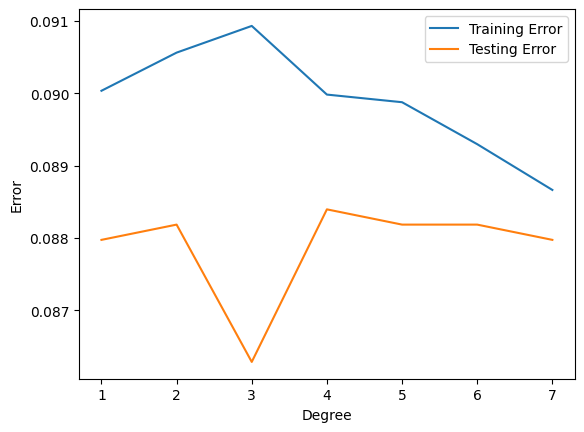

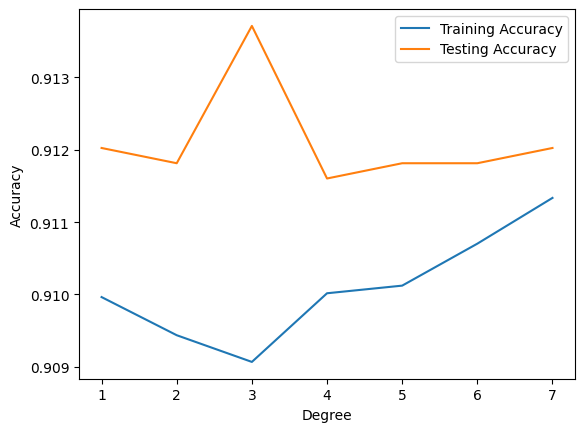

In [113]:
plot(training_error, testing_error, training_acc, testing_acc)


# 4B SVM

In [87]:
# svmachine = SVC(kernel='rbf', C=1E6)
# svmachine.fit(X_train, Y_train)
# svmachine.score(X_train, Y_train)

In [88]:
def polynomial_svm(X_train, Y_train, X_test, Y_test, max_degree=6):
    """Polynomial Support Vector Machine

    Args:
        X_train (np.array): Training data
        Y_train (np.array): Training labels
        X_test (np.array): Testing data
        Y_test (np.array): Testing labels
    """
    training_error, testing_error = [], []
    training_acc, testing_acc = [], []

    print("Polynomial SVM Score")
    print("Degree \t Test Score \t Train Score")
    for i in range(1, max_degree + 1):
        svmachine = SVC(kernel="linear")

        # Init polynomial features
        poly = PolynomialFeatures(degree=i)

        # # Polynomial fit of training data
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.fit_transform(X_test)

        svmachine.fit(X_train_poly, Y_train)
        # Get scores
        training_score = svmachine.score(X_train_poly, Y_train)
        testing_score = svmachine.score(X_test_poly, Y_test)

        # Append accuracy
        training_acc.append(training_score)
        testing_acc.append(testing_score)

        # Append errors
        training_error.append(1 - training_score)
        testing_error.append(1 - testing_score)

        # Fancy print B)
        print(f"{i} \t {testing_score*100.0:.2f}% \t {training_score*100.0:.2f}%")

    return training_error, testing_error, training_acc, testing_acc


In [89]:
training_error, testing_error, training_acc, testing_acc = polynomial_svm(
    X_train, Y_train, X_test, Y_test, max_degree=5
)


Polynomial SVM Score
Degree 	 Test Score 	 Train Score
1 	 91.27% 	 90.85%
2 	 91.12% 	 90.91%
3 	 91.08% 	 90.76%
4 	 91.24% 	 90.91%
5 	 90.93% 	 90.73%


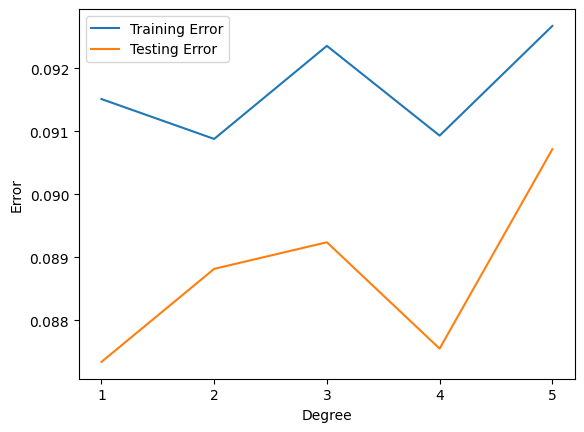

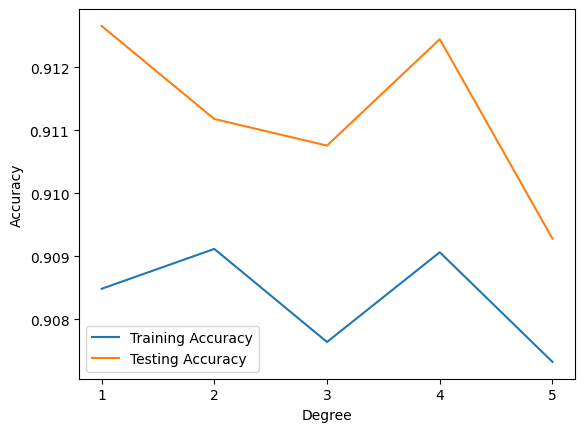

In [90]:
plot(training_error, testing_error, training_acc, testing_acc)


# 4C Neural Network

In [121]:
# Define the model architecture
model = Sequential(
    [Dense(4, activation="elu", input_shape=(3,)), Dense(2, activation="elu")]
)

# Compile the model with an optimizer, loss function, and metrics
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

# Train the model on the training data
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

Epoch 1/100
593/593 [==============================] - 1s 1ms/step - loss: 0.1376 - accuracy: 0.4898 - val_loss: 0.0912 - val_accuracy: 0.4015
Epoch 2/100
593/593 [==============================] - 1s 906us/step - loss: 0.0915 - accuracy: 0.4036 - val_loss: 0.0872 - val_accuracy: 0.4224
Epoch 3/100
593/593 [==============================] - 1s 892us/step - loss: 0.0885 - accuracy: 0.3980 - val_loss: 0.0847 - val_accuracy: 0.3895
Epoch 4/100
593/593 [==============================] - 1s 917us/step - loss: 0.0860 - accuracy: 0.3848 - val_loss: 0.0821 - val_accuracy: 0.3966
Epoch 5/100
593/593 [==============================] - 1s 910us/step - loss: 0.0821 - accuracy: 0.3765 - val_loss: 0.0760 - val_accuracy: 0.3696
Epoch 6/100
593/593 [==============================] - 1s 900us/step - loss: 0.0753 - accuracy: 0.3559 - val_loss: 0.0703 - val_accuracy: 0.3331
Epoch 7/100
593/593 [==============================] - 1s 917us/step - loss: 0.0715 - accuracy: 0.3153 - val_loss: 0.0678 - val_accu